Ryan's: https://colab.research.google.com/drive/1zb7uTL7PioW79iCR5t3iKAwcOBVoDPMJ

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

### Objective
- Visualize and interpret partial dependence plots

### Links
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)



### Three types of model explanations this unit:

#### 1. Global model explanation: all features in relation to each other _(Last Week)_
- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

#### 2. Global model explanation: individual feature(s) in relation to target _(Today)_
- Partial Dependence plots

#### 3. Individual prediction explanation _(Tomorrow)_
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

### Setup

#### If you're using [Anaconda](https://www.anaconda.com/distribution/) locally

Install required Python packages, if you haven't already:

- [category_encoders](https://github.com/scikit-learn-contrib/categorical-encoding), version >= 2.0: `conda install -c conda-forge category_encoders` / `pip install category_encoders`
- [PDPbox](https://github.com/SauceCat/PDPbox): `pip install pdpbox`
- [Plotly](https://medium.com/plotly/plotly-py-4-0-is-here-offline-only-express-first-displayable-anywhere-fc444e5659ee), version >= 4.0


## Lending Club: Predict interest rate

In [1]:
import pandas as pd

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history_location = '../data/lending-club/lending-club-subset.csv'
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Just use 36 month loans
history = history[history.term==' 36 months']

# Index & sort by issue date
history = history.set_index('issue_d').sort_index()

# Clean data, engineer feature, & select subset of features
history = history.rename(columns=                     
    {'annual_inc': 'Annual Income', 
     'fico_range_high': 'Credit Score', 
     'funded_amnt': 'Loan Amount', 
     'title': 'Loan Purpose'})

history['Interest Rate'] = history['int_rate'].str.strip('%').astype(float)
history['Monthly Debts'] = history['Annual Income'] / 12 * history['dti'] / 100

columns = ['Annual Income', 
           'Credit Score', 
           'Loan Amount', 
           'Loan Purpose', 
           'Monthly Debts', 
           'Interest Rate']

history = history[columns]
history = history.dropna()

# Test on the last 10,000 loans,
# Validate on the 10,000 before that,
# Train on the rest
test = history[-10000:]
val = history[-20000:-10000]
train = history[:-20000]

In [2]:
# Assign to X, y
target = 'Interest Rate'
features = history.columns.drop('Interest Rate')

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

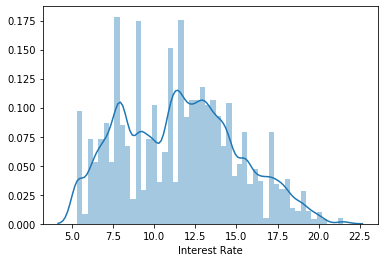

In [3]:
# The target has some right skew.
# It's not bad, but we'll log transform anyways
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

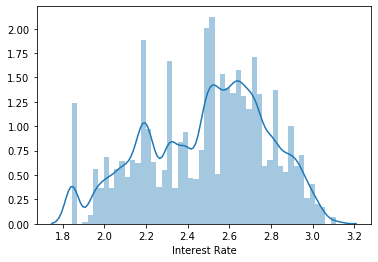

In [4]:
# Log transform the target
import numpy as np
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)
y_test_log = np.log1p(y_test)

# Plot the transformed target's distribution
sns.distplot(y_train_log);

# Tanzania Waterpump
Quantity
- `enough`
- `insufficient`
- `dry`

This would work with a linear model *

dry = 1, insufficient = 2, enough = 3

enough = 1, insufficient = 2, dry = 3


This wouldn't work with a linear model, but would with trees:

insufficient = 1, dry = 2, enough = 3


* But maybe not as well as you'd hope. It depends on whether the rate of change is constant between a dry waterpump vs an insufficient waterpump vs a waterpump with enough quantity of water.


dry = 9% functional

insufficient = 50 % functional

enough = 65% functional


What coefficient would Logistic Regression?

Coefficient: 28%

### Fit Linear Regression model, with original target

In [5]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.OrdinalEncoder(), # Not ideal for Linear Regression 
    StandardScaler(), 
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 0.21454894710371242


### Fit Gradient Boosting model, with log transformed target

In [6]:
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train_log)
y_pred_log = gb.predict(X_val)
y_pred = np.expm1(y_pred_log)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))
# print('Gradient Boosting R^2', gb.score(X_val, y_val_log))
# Convert back away from log space

/home/ygeun/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Gradient Boosting R^2 0.23227458654291155


### Explaining Linear Regression

In [7]:
example = X_val.iloc[[0]]
example

,Annual Income,Credit Score,Loan Amount,Loan Purpose,Monthly Debts
issue_d,,,,,
2016-12-01,68700.0,729.0,7150.0,Credit card refinancing,1452.4325


In [8]:
pred = lr.predict(example)[0]
print(f'Predicted Interest Rate: {pred:.2f}%')

Predicted Interest Rate: 9.96%


In [9]:
def predict(model, example, log=False):
    print('Vary income, hold other features constant', '\n')
    example = example.copy()
    preds = []
    for income in range(20000, 200000, 20000):
        example['Annual Income'] = income
        pred = model.predict(example)[0]
        if log:
            pred = np.expm1(pred)
        print(f'Predicted Interest Rate: {pred:.3f}%')
        print(example.to_string(), '\n')
        preds.append(pred)
    print('Difference between predictions')
    print(np.diff(preds))
        
predict(lr, example)

Vary income, hold other features constant 

Predicted Interest Rate: 10.117%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          20000         729.0       7150.0  Credit card refinancing      1452.4325 

Predicted Interest Rate: 10.052%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          40000         729.0       7150.0  Credit card refinancing      1452.4325 

Predicted Interest Rate: 9.987%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          60000         729.0       7150.0  Credit card refinancing      1452.4325 

Predicted Inter

In [10]:
example2 = X_val.iloc[[2]]
predict(lr, example2);

Vary income, hold other features constant 

Predicted Interest Rate: 12.513%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          20000         684.0       9900.0  Credit card refinancing    1600.958333 

Predicted Interest Rate: 12.448%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          40000         684.0       9900.0  Credit card refinancing    1600.958333 

Predicted Interest Rate: 12.383%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          60000         684.0       9900.0  Credit card refinancing    1600.958333 

Predicted Inte

### Explaining Gradient Boosting???

In [11]:
predict(gb, example, log=True)

Vary income, hold other features constant 

Predicted Interest Rate: 10.861%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          20000         729.0       7150.0  Credit card refinancing      1452.4325 

Predicted Interest Rate: 10.456%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          40000         729.0       7150.0  Credit card refinancing      1452.4325 

Predicted Interest Rate: 8.733%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          60000         729.0       7150.0  Credit card refinancing      1452.4325 

Predicted Inter

In [12]:
predict(gb, example2, log=True)

Vary income, hold other features constant 

Predicted Interest Rate: 13.334%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          20000         684.0       9900.0  Credit card refinancing    1600.958333 

Predicted Interest Rate: 12.780%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          40000         684.0       9900.0  Credit card refinancing    1600.958333 

Predicted Interest Rate: 11.204%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          60000         684.0       9900.0  Credit card refinancing    1600.958333 

Predicted Inte

## Partial Dependence Plots

From [PDPbox documentation](https://pdpbox.readthedocs.io/en/latest/):


>**The common headache**: When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.

[Animation by Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904), author of [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/pdp.html#examples)

> Partial dependence plots show how a feature affects predictions of a Machine Learning model on average.
> 1. Define grid along feature
> 2. Model predictions at grid points
> 3. Line per data instance -> ICE (Individual Conditional Expectation) curve
> 4. Average curves to get a PDP (Partial Dependence Plot)

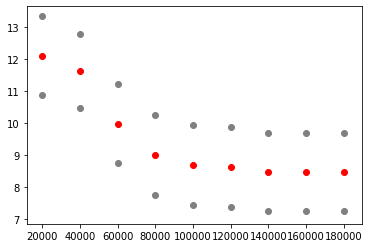

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

examples = pd.concat([example, example2])
for income in range(20000, 200000, 20000):
    examples['Annual Income'] = income
    preds_log = gb.predict(examples)
    preds = np.expm1(preds_log)
    for pred in preds:
        plt.scatter(income, pred, color='grey')
    plt.scatter(income, np.mean(preds), color='red')

## Partial Dependence Plots with 1 feature

#### PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html)
- [API Reference: pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html)

In [14]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


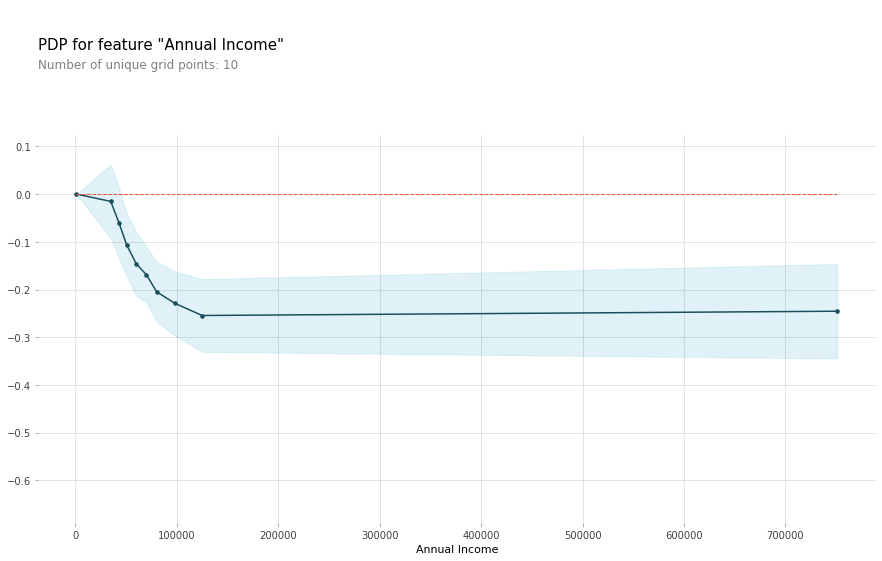

In [15]:
from pdpbox.pdp import pdp_plot, pdp_isolate

feature = 'Annual Income'
isolated = pdp_isolate(
    # Pipeline w/ gradient boosting at end
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

(0, 150000)

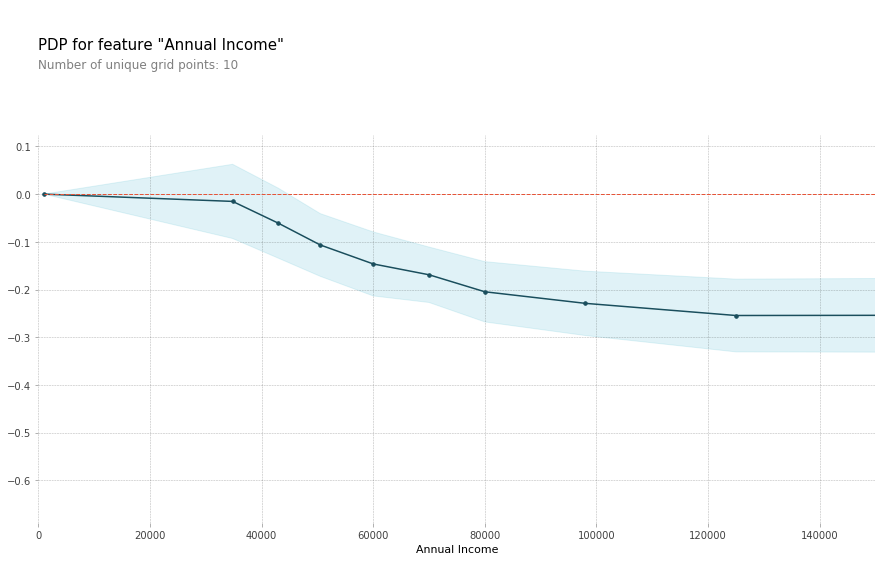

In [16]:
pdp_plot(isolated, feature_name=feature)
# ZOOM IN
plt.xlim(0,150000)

(0, 150000)

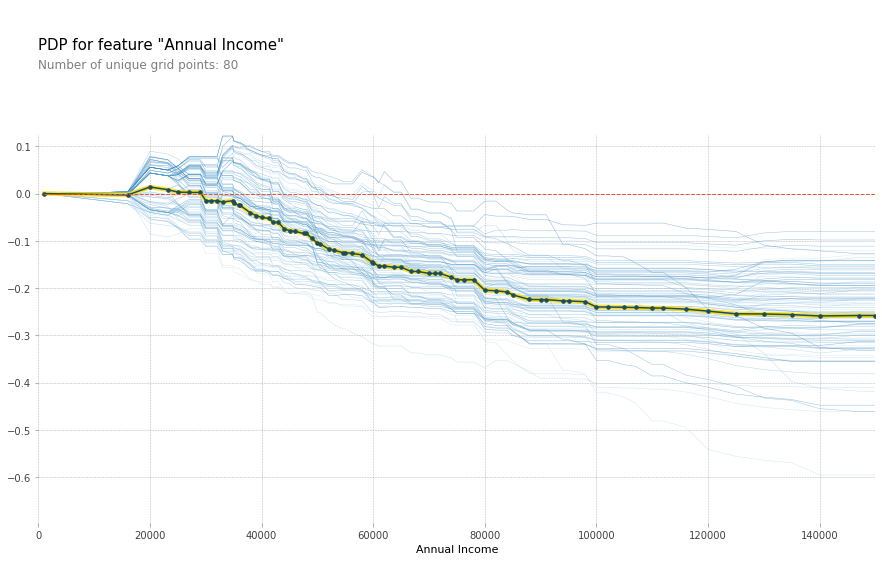

In [17]:
isolated = pdp_isolate(
    # Pipeline w/ gradient boosting at end
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    feature=feature,
    num_grid_points=100
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100);
plt.xlim(0,150000)

#### You can customize it

PDPbox
- [API Reference: PDPIsolate](https://pdpbox.readthedocs.io/en/latest/PDPIsolate.html)

In [18]:
grid = isolated.feature_grids

Text(0.5, 1.0, 'Dependence Plot')

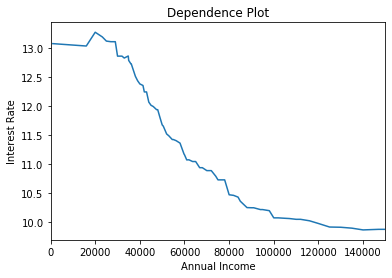

In [19]:
grid
pdp_log = isolated.pdp
# bring it back to normal units
pdp = np.expm1(pdp_log)

plt.plot(grid, pdp)
plt.xlim(0,150000)
plt.xlabel('Annual Income')
plt.ylabel('Interest Rate')
plt.title("Dependence Plot")

(0, 150000)

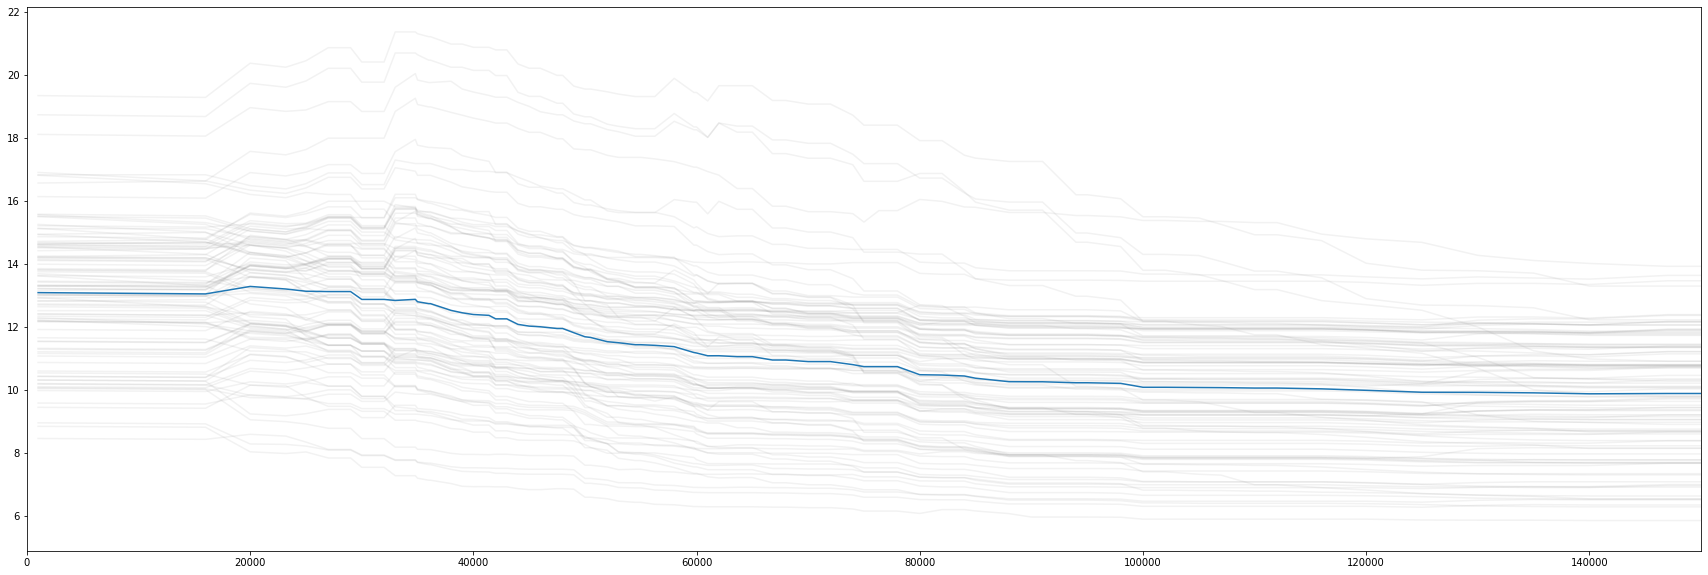

In [20]:
# It's a pandas dataframe, transposed headers are borders essentially.
ice_log = isolated.ice_lines.sample(n=100).T # still in log spcae remember
ice = ice_log.apply(np.expm1)

ice.plot(color='grey',alpha=0.1,legend=False,figsize=(30,10))
plt.plot(grid,pdp)

plt.xlim(0,150000)

## Partial Dependence Plots with 2 features

See interactions!

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_interact](https://pdpbox.readthedocs.io/en/latest/pdp_interact.html)
- [API Reference: pdp_interact_plot](https://pdpbox.readthedocs.io/en/latest/pdp_interact_plot.html)

Be aware of a bug in PDPBox version <= 0.20:
- With the `pdp_interact_plot` function, `plot_type='contour'` gets an error, but `plot_type='grid'` works
- This will be fixed in the next release of PDPbox: https://github.com/SauceCat/PDPbox/issues/40

(<Figure size 540x684 with 3 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fca709baef0>,
  'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fca7097e7f0>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


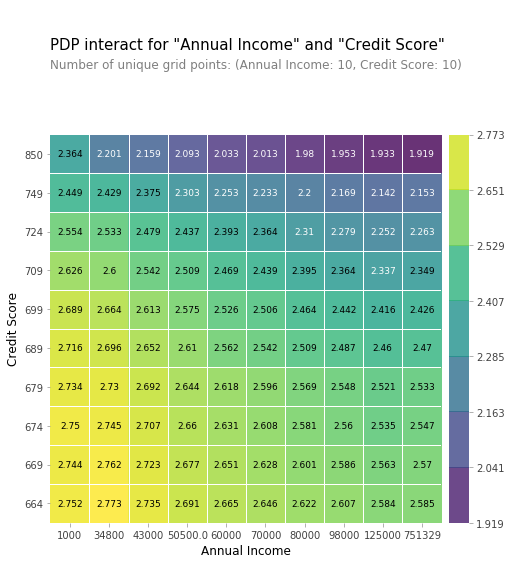

In [21]:
# Two dif functions
from pdpbox.pdp import pdp_interact, pdp_interact_plot

interaction = pdp_interact(
    model=gb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)
pdp_interact_plot(interaction, plot_type='grid', feature_names=features) # has to be grid instead of contour cause of bug

Text(0.5, 1, 'Partial Dep. of Int. Rate on Ann. Income & Credit Score')

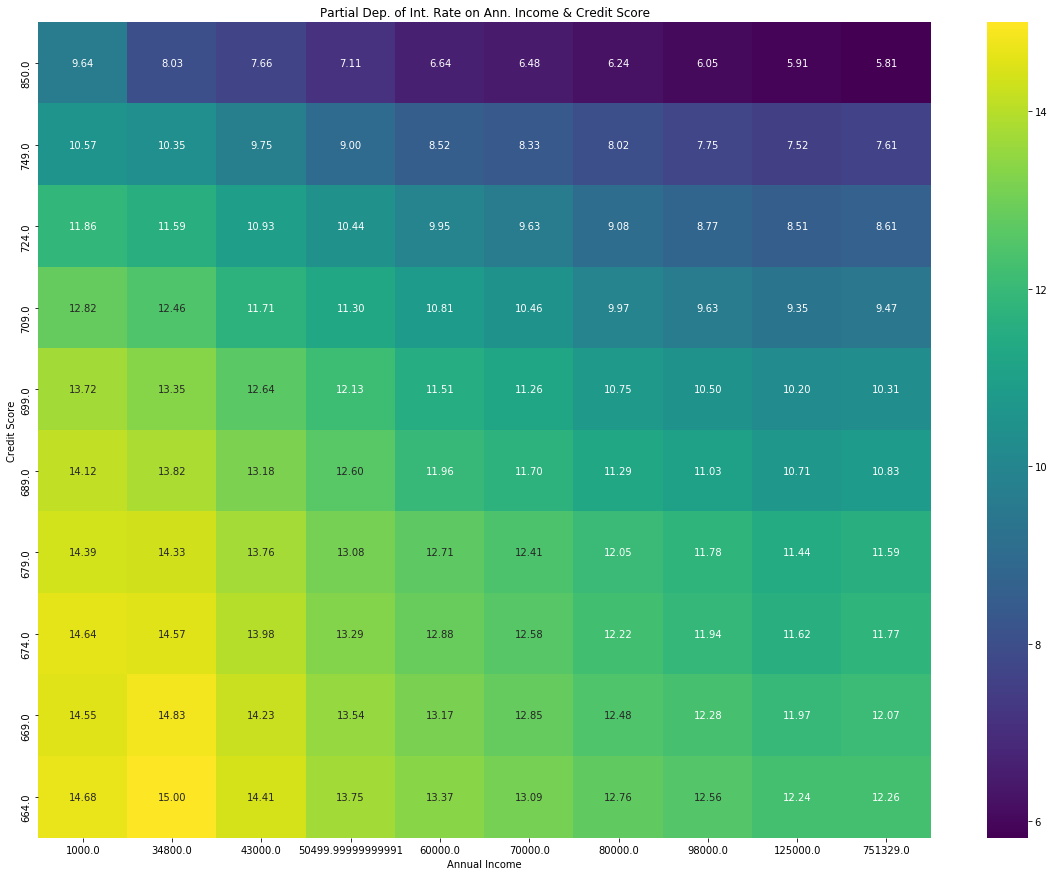

In [22]:
#interaction.pdp # a dataframe saying for each of 100 combos of a certain thing, what was predicted in log units
pdp_log = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0],
    index=features[1]
)[::-1] # slice notation, to reverse index order so y-axis is ascending

# Turn the log back into normal units
pdp = pdp_log.apply(np.expm1)
plt.figure(figsize=(20,15))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dep. of Int. Rate on Ann. Income & Credit Score')
# NOT APPLICABLE IF DOING CLASSIFCATION PROBZ
# But w/ multiple classification problems it's complex
# might want to convert your multiple classification problem to binary so that you only have
# to do one pdp problem

### 3D with Plotly!

In [ ]:
import plotly.graph_objs as go
surface = go.Surface(x=pdp.columns,
                     y=pdp.index,
                     z=pdp.values)

fig = go.Figure(surface)
fig.show()

# Partial Dependence Plots with categorical features

1. I recommend you use Ordinal Encoder, outside of a pipeline, to encode your data first. Then use the encoded data with pdpbox.
2. There's some extra work to get readable category names on your plot, instead of integer category codes.

In [24]:
# Fit a model on Titanic data
import category_encoders as ce
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

df = sns.load_dataset('titanic')
df.age = df.age.fillna(df.age.median())
df = df.drop(columns='deck')
df = df.dropna()

target = 'survived'
features = df.columns.drop(['survived', 'alive'])

X = df[features]
y = df[target]

# Use Ordinal 
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

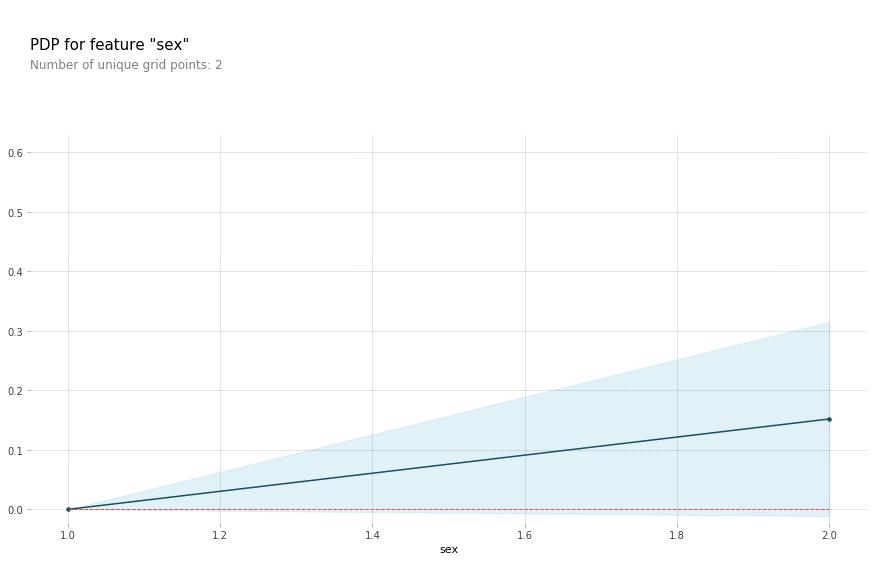

In [25]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'sex'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [26]:
# Look at the encoder's mappings
encoder.mapping

[{'col': 'sex', 'mapping': male      1
  female    2
  NaN      -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'embarked', 'mapping': S      1
  C      2
  Q      3
  NaN   -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'class', 'mapping': First     1
  Second    2
  Third     3
  NaN      -2
  dtype: int64, 'data_type': CategoricalDtype(categories=['First', 'Second', 'Third'], ordered=False)},
 {'col': 'who', 'mapping': man      1
  woman    2
  child    3
  NaN     -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'embark_town', 'mapping': Southampton    1
  Cherbourg      2
  Queenstown     3
  NaN           -2
  dtype: int64, 'data_type': dtype('O')}]

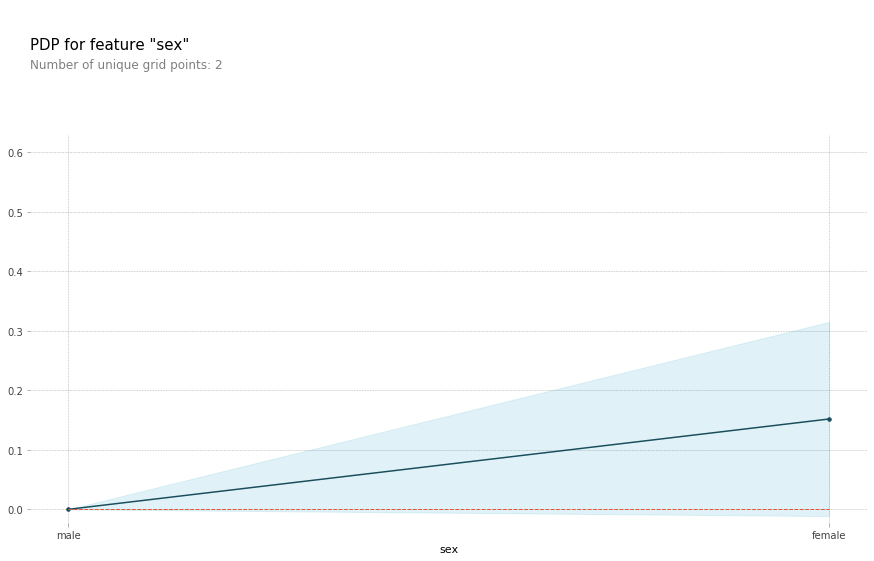

In [27]:
pdp.pdp_plot(pdp_dist, feature)

# Manually change the xticks labels
plt.xticks([1, 2], ['male', 'female']);

In [28]:
# Let's automate it

feature = 'sex'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']

feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

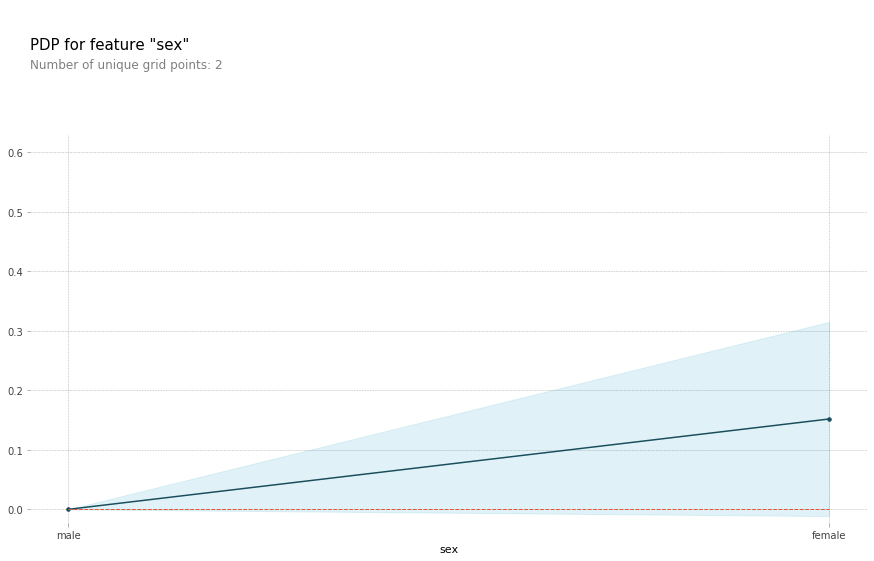

In [29]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'sex'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature)

# Automatically change the xticks labels
plt.xticks(category_codes, category_names);

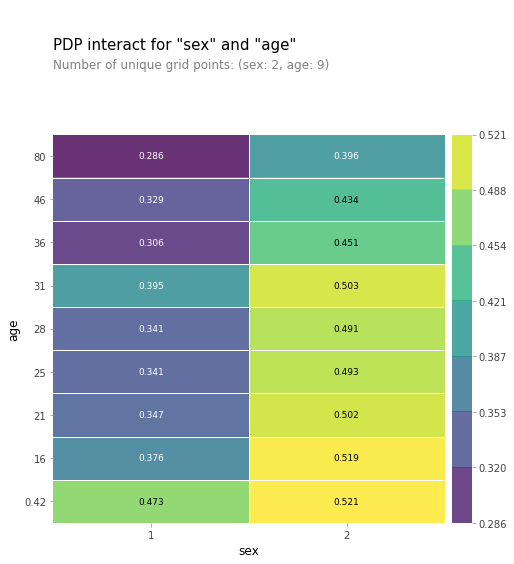

In [30]:
features = ['sex', 'age']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

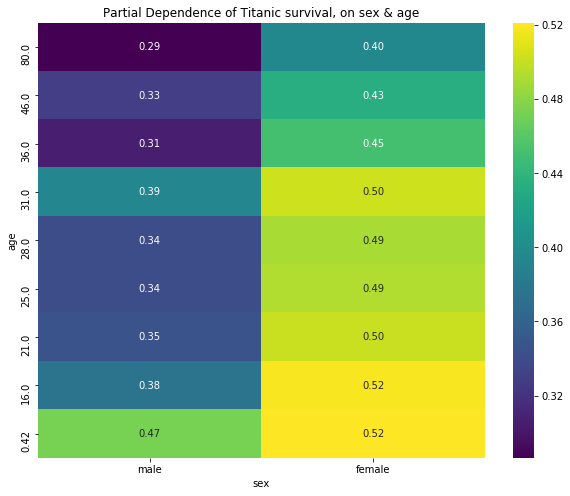

In [31]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))

plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence of Titanic survival, on sex & age');